### **Understanding Barren Plateaus in Variational Quantum Algorithms**
Barren plateaus refer to regions in the parameter space of a cost function where the gradient variance is extremely small, effectively making the landscape of the cost function flat. In simpler terms, if a variational quantum circuit is initialized in one of these regions, gradient-based optimization algorithms will struggle to train it because the gradients provide almost no guidance for parameter updates.

In the study *“Cost-Function-Dependent Barren Plateaus in Shallow Quantum Neural Networks”* by Cerezo et al., the authors show that barren plateaus can sometimes be avoided by using **local cost functions**. Unlike global cost functions, which depend on measurements from all qubits in the circuit, local cost functions only consider a subset of qubits. This partial perspective allows the gradients to be better-behaved, even in shallow circuits, and can make the optimization more robust to noise.

Many variational quantum algorithms traditionally use **global cost functions**, which aggregate information from all qubits to compute a single scalar value representing the circuit's performance. A **local cost function**, on the other hand, focuses only on a few qubits while attempting to infer information about the circuit's overall behavior. This can mitigate the barren plateau problem because the gradient information remains significant and non-vanishing.

Cerezo et al. also prove that local cost functions are **bounded by their corresponding global cost functions**. Specifically, for a properly formulated global cost function, the value of the local cost function will never exceed the global one. This ensures that using local cost functions does not introduce inconsistencies or unbounded behavior in optimization.

In this notebook, we explore the impact of barren plateaus on variational quantum algorithms and examine how local cost functions can help reduce their effect.
Let's first import the modules,


In [1]:
from imports import *
seed_val = 20
np.random.seed(seed_val) # The seed value is set for reproducibility

### **Lets Visualize the Problem!**

To better understand barren plateaus, we first consider a simple task: learning the **identity gate** across multiple qubits. The identity gate leaves the quantum state unchanged, so the goal of the variational circuit is to reproduce the input state at the output. This setup provides a clear way to visualize how the cost function behaves across different parameter values, helping us see regions of flat gradients (barren plateaus) and regions where optimization is possible. The number of qubits (or "wires") we choose to train on significantly affects the results. As shown in the work by Cerezo et al., the trainability of a variational circuit depends on the number of qubits and the depth of the circuit. Training on more qubits increases the likelihood of encountering barren plateaus when using global cost functions, whereas local cost functions are more resilient in these larger systems. In this example, we simulate the quantum circuit using a **statevector simulator**, which allows us to obtain exact probabilities of measurement outcomes. We also use a relatively large number of shots to approximate the expected measurement statistics, which is necessary for evaluating the cost function accurately.

In [2]:
wires = 6
dev = qml.device("lightning.qubit", wires=wires, shots=10000)

### **Defining the Circuit Ansatz and Cost Functions**

Next, we define the **quantum circuit ansatz** and the associated cost functions. For this simple example, a suitable ansatz consists of **single-qubit rotations around the X and Y axes** on each qubit. These rotations are repeated across all qubits in the system.

Since the goal is to learn the **identity gate**, a natural choice for the cost function is based on the probability of measuring the qubits in the zero state. If we denote the output state of the circuit as $|\phi(\alpha)\rangle$ for parameters $\alpha$, then a single-qubit cost can be written as:

$$
F = \langle \phi(\alpha) | I - |0\rangle \langle 0| | \phi(\alpha) \rangle = 1 - p_0
$$

where $p_0$ is the probability of measuring the zero state for that qubit.

For a **global cost function**, we consider the joint probability of all qubits being in the zero state:

$$
F_{\mathrm{global}} = \langle \phi(\alpha) | I - |00...0\rangle \langle 00...0| | \phi(\alpha) \rangle = 1 - p_{00...0}
$$

Here, $p_{00...0}$ is the probability of all qubits being in the zero state simultaneously.

For a **local cost function**, we sum the contributions of each qubit individually and average them:

$$
F_{\mathrm{local}} = \langle \phi(\alpha) | I - \frac{1}{m} \sum_{k=1}^{m} |0\rangle \langle 0|_k | \phi(\alpha) \rangle = 1 - \frac{1}{m} \sum_{k=1}^{m} p_0^{(k)}
$$

where $m$ is the total number of qubits, and $p_0^{(k)}$ is the probability of measuring qubit $k$ in the zero state.  

Intuitively, the local cost function can perform better because it breaks the global problem into **smaller, single-qubit subproblems**, each contributing to the overall cost. This division helps avoid barren plateaus since the gradients for individual qubits remain significant, even when the global landscape might be flat.

In practice, we implement **separate QNodes** for the global and local cost functions. The global QNode returns the joint probability of all qubits, while the local QNode returns probabilities for each qubit individually. The final cost functions are then calculated by subtracting these probabilities from one and, in the local case, averaging over all qubits.

In [3]:
def global_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    return qml.probs(wires=range(wires))

def local_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    return [qml.probs(wires=i) for i in range(wires)]

global_circuit = qml.QNode(global_cost_simple, dev, interface="autograd")

local_circuit = qml.QNode(local_cost_simple, dev, interface="autograd")

def cost_local(rotations):
    return 1 - np.sum([i for (i, _) in local_circuit(rotations)]) / wires

def cost_global(rotations):
    return 1 - global_circuit(rotations)[0]

To evaluate the behavior of our variational circuits, we begin by assigning **random initial parameters** to each rotation gate. Random initialization is a common practice in variational quantum algorithms because it provides a starting point in the parameter space without any prior bias. The values are typically chosen uniformly from the interval $[-\pi, \pi]$ for rotational gates.

Let us denote the rotation parameters for each qubit as $\theta_x$ and $\theta_y$, corresponding to rotations around the X and Y axes, respectively. Then, for a system of $m$ qubits, the parameter set can be represented as:

$$
\Theta = 
\begin{bmatrix}
\theta_x^{(1)} & \theta_x^{(2)} & \dots & \theta_x^{(m)} \\
\theta_y^{(1)} & \theta_y^{(2)} & \dots & \theta_y^{(m)}
\end{bmatrix}
$$

Each $\theta_x^{(k)}$ and $\theta_y^{(k)}$ is drawn randomly from $[-\pi, \pi]$. This randomly initialized parameter set is then fed into the circuit to compute the corresponding global or local cost function.

In [4]:
RX = np.random.uniform(low=-np.pi, high=np.pi)
RY = np.random.uniform(low=-np.pi, high=np.pi)
rotations = [[RX for i in range(wires)], [RY for i in range(wires)]]

### **Results**

Global Cost:  0.5897000
Local Cost:  0.1362000


Matplotlib is building the font cache; this may take a moment.


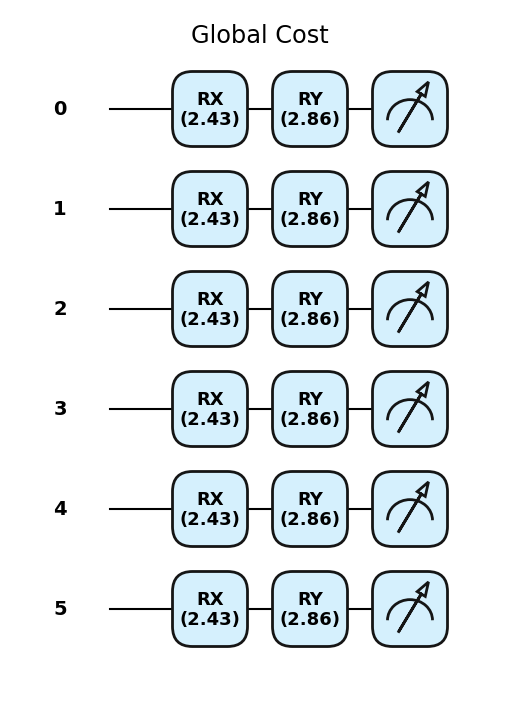

In [5]:
print("Global Cost: {: .7f}".format(cost_global(rotations)))
print("Local Cost: {: .7f}".format(cost_local(rotations)))

qml.drawer.use_style('black_white')
fig1, ax1 = qml.draw_mpl(global_circuit, decimals=2, style = "pennylane")(rotations)
fig1.suptitle("Global Cost", fontsize='xx-large')
plt.show()

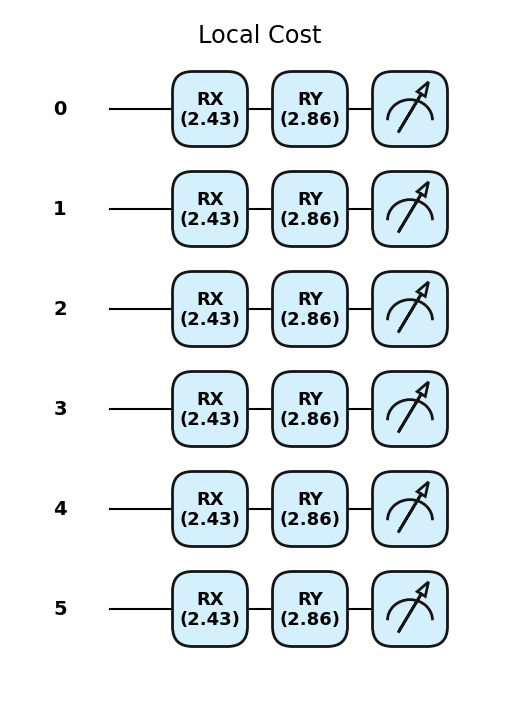

In [6]:
fig2, ax2 = qml.draw_mpl(local_circuit, decimals=2, style = "pennylane")(rotations)
fig2.suptitle("Local Cost", fontsize='xx-large')
plt.show()

With this simplified example, we can graphically visualize the cost function and observe the barren plateau effect. Although a system with $m$ qubits has $2m$ parameters (one X-rotation and one Y-rotation per qubit), plotting the full landscape in high dimensions is impractical. To simplify visualization, we consider a constrained scenario where all X rotations share the same value $\theta_x$** and **all Y rotations share the same value $\theta_y$. This reduces the problem to a 2-dimensional landscape that can be easily plotted.

We first examine the global cost function. When plotted for a system of six qubits, most of the cost landscape appears **flat**, indicating large regions where the gradient is nearly zero. Even with a shallow circuit (depth = 2), optimization in these flat regions is extremely difficult. As the number of qubits increases, this flatness becomes more pronounced, making training with gradient-based methods progressively harder. This visualization clearly demonstrates the **barren plateau phenomenon**, where the optimizer receives almost no guidance from the gradient in large regions of the parameter space.

The process of generating and plotting the surface involves evaluating the cost function on a **grid of X and Y rotation values**, and then creating a 3D plot to show the cost value for each combination of $\theta_x$ and $\theta_y$. This provides an intuitive picture of how flat regions dominate the landscape for global cost functions in multi-qubit systems.

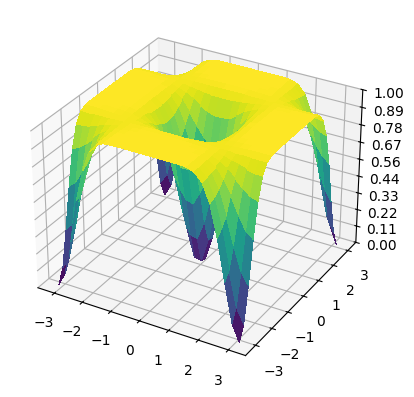

In [7]:
def generate_surface(cost_function):
    Z = []
    Z_assembler = []

    X = np.arange(-np.pi, np.pi, 0.25)
    Y = np.arange(-np.pi, np.pi, 0.25)
    X, Y = np.meshgrid(X, Y)

    for x in X[0, :]:
        for y in Y[:, 0]:
            rotations = [[x for i in range(wires)], [y for i in range(wires)]]
            Z_assembler.append(cost_function(rotations))
        Z.append(Z_assembler)
        Z_assembler = []

    Z = np.asarray(Z)
    return Z

def plot_surface(surface):
    X = np.arange(-np.pi, np.pi, 0.25)
    Y = np.arange(-np.pi, np.pi, 0.25)
    X, Y = np.meshgrid(X, Y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X, Y, surface, cmap="viridis", linewidth=0, antialiased=False)
    ax.set_zlim(0, 1)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
    plt.show()


global_surface = generate_surface(cost_global)
plot_surface(global_surface)

When we switch from the global to the local cost function, the cost landscape becomes significantly more trainable.

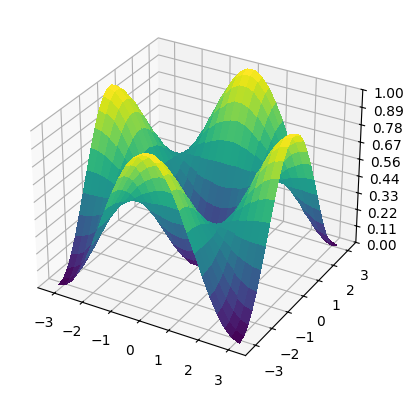

In [11]:
local_surface = generate_surface(cost_local)
plot_surface(local_surface)

### **Training the Circuits to Assess Trainability**

Visualizing the cost landscape gives intuition, but to truly assess **trainability**, we need to perform actual optimization. To simplify the local cost function for this experiment, we modify it from summing over all qubits:
$$
F_{\mathrm{local}} = 1 - \sum_k p_0^{(k)}
$$

to considering only a **single qubit**:

$$
F_{\mathrm{local}} = 1 - p_0^{(1)}
$$

where $p_0^{(1)}$ is the probability of the first qubit being in the zero state. This simplification allows us to study how local measurements affect the gradient and training dynamics without averaging over multiple qubits.

We also enhance the ansatz to resemble a **typical VQE-style circuit** by adding entangling gates. In this case, **CNOT gates** between neighboring qubits introduce entanglement, which is essential for capturing correlations in quantum systems. The variational circuit now consists of alternating single-qubit rotations ($\theta_x$ and $\theta_y$) followed by a chain of CNOT gates connecting adjacent qubits. The global cost function still measures the probability of all qubits being in the zero state, whereas the local cost function now only depends on the measurement of the first qubit. By comparing training outcomes for these two cost functions, we can directly observe how local observables can reduce barren plateaus and improve optimization, even in the presence of entanglement and more realistic circuit architectures.

In [8]:
def global_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    for i in range(wires - 1):
        qml.CNOT([i, i + 1])
    return qml.probs(wires=range(wires))

def local_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    for i in range(wires - 1):
        qml.CNOT([i, i + 1])
    return qml.probs(wires=[0])

global_circuit = qml.QNode(global_cost_simple, dev, interface="autograd")

local_circuit = qml.QNode(local_cost_simple, dev, interface="autograd")

def cost_local(rotations):
    return 1 - local_circuit(rotations)[0]

def cost_global(rotations):
    return 1 - global_circuit(rotations)[0]

Lets see the cost landscape now!

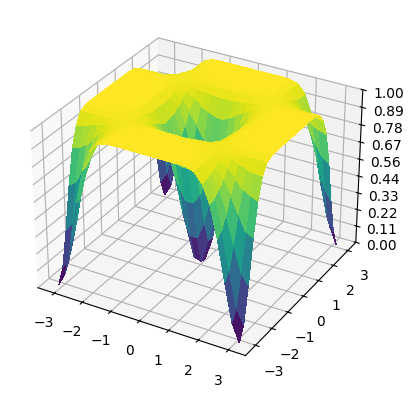

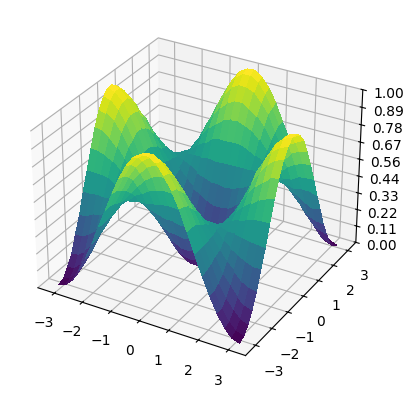

In [9]:
global_surface = generate_surface(cost_global)
plot_surface(global_surface)

local_surface = generate_surface(cost_local)
plot_surface(local_surface)

Although modifying the ansatz and cost functions slightly changed the circuit, the overall cost landscape remains largely similar, which is somewhat surprising. To test trainability rigorously, we now start optimization from a challenging point** in the parameter space. From our previous visualization, one of the worst points on the global cost landscape is $(\theta_x, \theta_y) = (\pi, 0)$, which lies roughly in the middle of a barren plateau. Starting here allows us to exaggerate the difficulty of gradient-based training and observe how the optimizer behaves in nearly flat regions.

We initialize the parameters for all qubits with $\theta_x = 3.0$ and $\theta_y = 0.0$, and perform gradient descent using a stepsize $\eta = 0.2$ for 100 steps. During training, we monitor the global cost function every few steps to see whether the optimizer can escape the plateau.  

Even with a relatively simple circuit, starting in the middle of a plateau demonstrates why global cost functions are challenging to train: the gradients are extremely small, so the optimizer takes tiny steps and progress is slow. Visualizing the trained circuit afterward helps us verify the final parameter configuration and understand how the optimization struggled or succeeded in reaching a lower cost.

This experiment provides a clear, practical example of the barren plateau phenomenon and sets the stage for comparing the training performance of **global vs. local cost functions**.

Cost after step     5:  1.0000000
Cost after step    10:  1.0000000
Cost after step    15:  1.0000000
Cost after step    20:  1.0000000
Cost after step    25:  1.0000000
Cost after step    30:  1.0000000
Cost after step    35:  1.0000000
Cost after step    40:  1.0000000
Cost after step    45:  1.0000000
Cost after step    50:  1.0000000
Cost after step    55:  1.0000000
Cost after step    60:  1.0000000
Cost after step    65:  1.0000000
Cost after step    70:  1.0000000
Cost after step    75:  1.0000000
Cost after step    80:  1.0000000
Cost after step    85:  1.0000000
Cost after step    90:  1.0000000
Cost after step    95:  1.0000000
Cost after step   100:  1.0000000


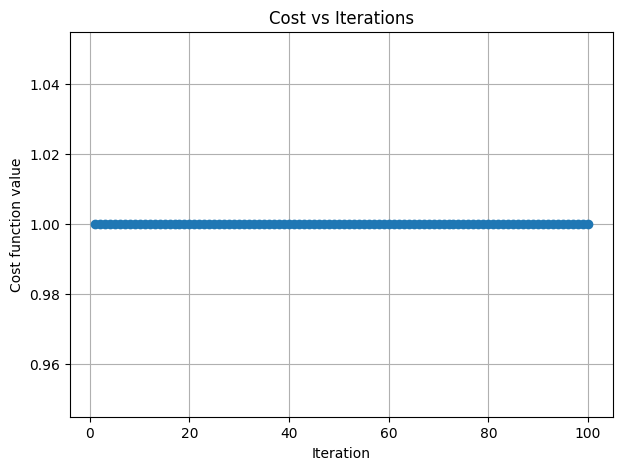

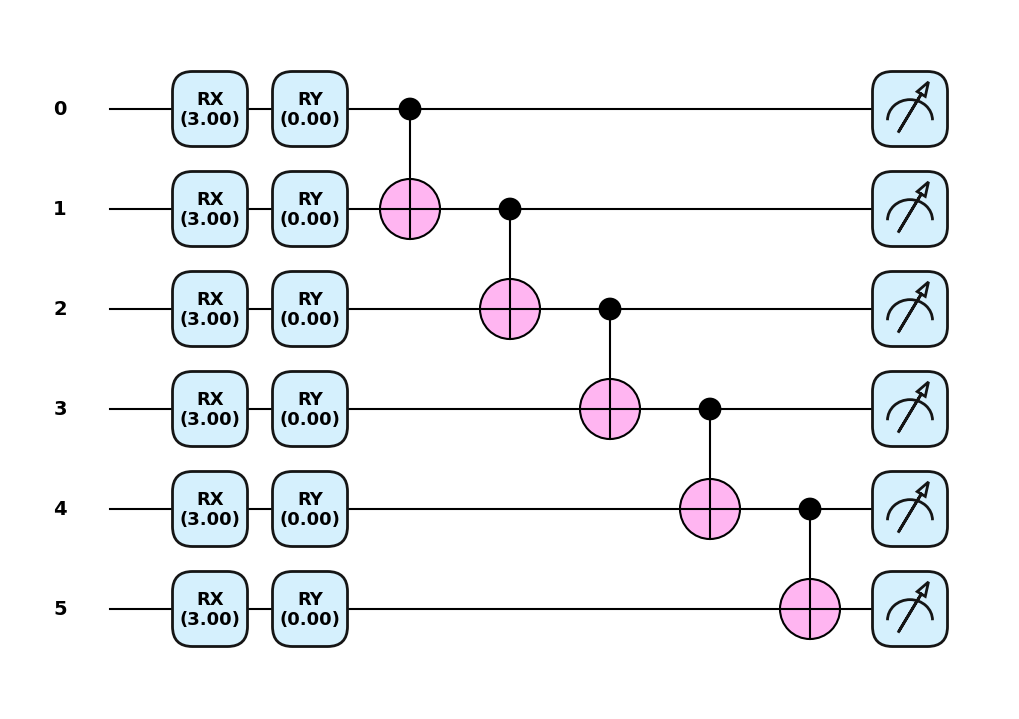

In [13]:
# rotations = np.array([[3.] * len(range(wires)), [0.] * len(range(wires))], requires_grad=True)
# opt = qml.GradientDescentOptimizer(stepsize=0.2)
# steps = 100
# params_global = rotations
# for i in range(steps):
#     # update the circuit parameters
#     params_global = opt.step(cost_global, params_global)

#     if (i + 1) % 5 == 0:
#         print("Cost after step {:5d}: {: .7f}".format(i + 1, cost_global(params_global)))
#     if cost_global(params_global) < 0.1:
#         break
# fig, ax = qml.draw_mpl(global_circuit, decimals=2, style = "pennylane")(params_global)
# plt.show()
rotations = np.array([[3.] * len(range(wires)), [0.] * len(range(wires))], requires_grad=True)
opt = qml.GradientDescentOptimizer(stepsize=0.2)
steps = 100
params_global = rotations

# store costs
cost_history = []

for i in range(steps):
    # update params
    params_global = opt.step(cost_global, params_global)

    # record cost
    current_cost = cost_global(params_global)
    cost_history.append(current_cost)

    if (i + 1) % 5 == 0:
        print(f"Cost after step {i+1:5d}: {current_cost: .7f}")
    if current_cost < 0.1:
        break

# Plot cost vs iterations
plt.figure(figsize=(7,5))
plt.plot(range(1, len(cost_history)+1), cost_history, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Cost function value")
plt.title("Cost vs Iterations")
plt.grid(True)
plt.show()
fig, ax = qml.draw_mpl(global_circuit, decimals=2, style = "pennylane")(params_global)
plt.show()


### **Training with the Local Cost Function**

After training the **global cost function** for 100 steps from the plateau point $(\theta_x, \theta_y) = (\pi, 0)$, the cost remained at 1, confirming that the circuit is in an **“untrainable” region** due to the barren plateau. The optimizer makes virtually no progress because the gradients are nearly zero across all qubits.

We now repeat the training starting from the same initial parameters, but this time using the local cost function. The parameter initialization and optimization settings are identical: $\theta_x = 3.0$, $\theta_y = 0.0$ for all qubits, with a stepsize of 0.2 over 100 steps.

Unlike the global case, the local cost function receives gradient information from a single qubit, allowing the optimizer to make meaningful updates. As a result, the cost begins to decrease steadily, and convergence is achieved much faster. This demonstrates how local observables can mitigate the barren plateau problem, even when starting from a challenging point in the parameter space.

Cost after step     5:  0.9905000
Cost after step    10:  0.9667000
Cost after step    15:  0.9223000
Cost after step    20:  0.8181000
Cost after step    25:  0.6188000
Cost after step    30:  0.3746000
Cost after step    35:  0.1784000
Cost after step    40:  0.0667000


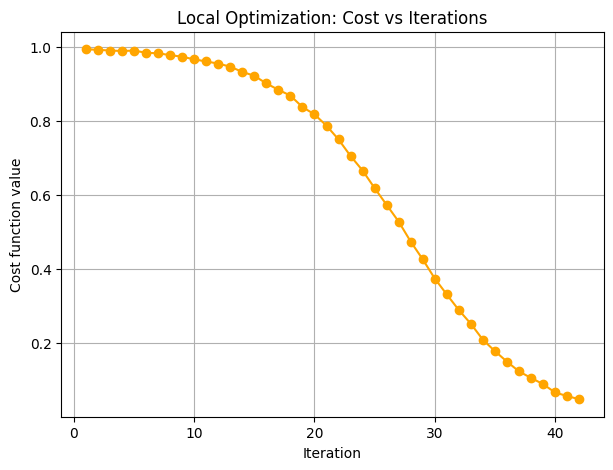

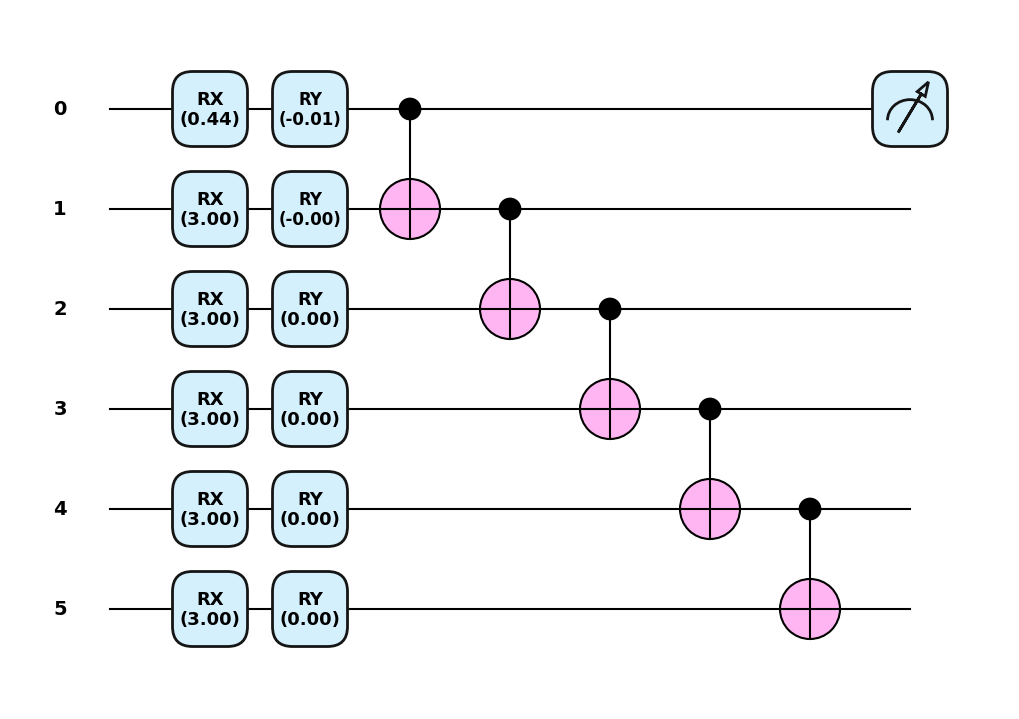

In [14]:
# rotations = np.array([[3. for i in range(wires)], [0. for i in range(wires)]], requires_grad=True)
# opt = qml.GradientDescentOptimizer(stepsize=0.2)
# steps = 100
# params_local = rotations
# for i in range(steps):
#     # update the circuit parameters
#     params_local = opt.step(cost_local, params_local)

#     if (i + 1) % 5 == 0:
#         print("Cost after step {:5d}: {: .7f}".format(i + 1, cost_local(params_local)))
#     if cost_local(params_local) < 0.05:
#         break

# fig, ax = qml.draw_mpl(local_circuit, decimals=2, style = "pennylane")(params_local)
# plt.show()
rotations = np.array([[3. for i in range(wires)], [0. for i in range(wires)]], requires_grad=True)
opt = qml.GradientDescentOptimizer(stepsize=0.2)
steps = 100
params_local = rotations

# store costs
cost_history_local = []

for i in range(steps):
    # update params
    params_local = opt.step(cost_local, params_local)

    # record cost
    current_cost = cost_local(params_local)
    cost_history_local.append(current_cost)

    if (i + 1) % 5 == 0:
        print(f"Cost after step {i+1:5d}: {current_cost: .7f}")
    if current_cost < 0.05:
        break

# Plot cost vs iterations
plt.figure(figsize=(7,5))
plt.plot(range(1, len(cost_history_local)+1), cost_history_local, marker="o", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Cost function value")
plt.title("Local Optimization: Cost vs Iterations")
plt.grid(True)
plt.show()

# Draw final circuit
fig, ax = qml.draw_mpl(local_circuit, decimals=2, style="pennylane")(params_local)
plt.show()


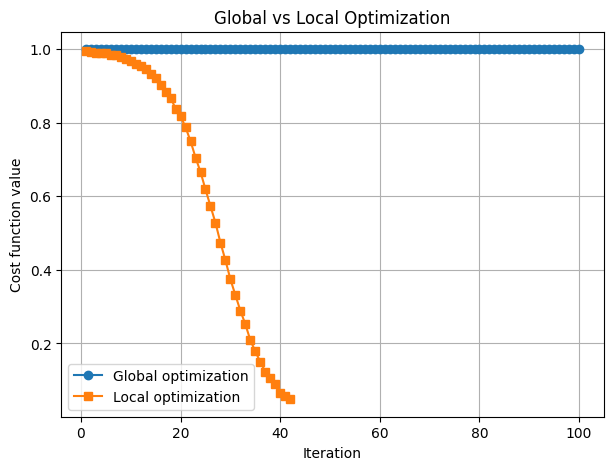

In [15]:
plt.figure(figsize=(7,5))
plt.plot(range(1, len(cost_history)+1), cost_history, marker="o", label="Global optimization")
plt.plot(range(1, len(cost_history_local)+1), cost_history_local, marker="s", label="Local optimization")

plt.xlabel("Iteration")
plt.ylabel("Cost function value")
plt.title("Global vs Local Optimization")
plt.legend()
plt.grid(True)
plt.show()

Training with the local cost function is much faster and effective compared to the global cost function, as we saw in the previous section. However, an interesting question arises: **Lets see how much has the global cost function actually improved after optimizing the local cost function?**

In [17]:
cost_global(params_local)

np.float64(1.0)

This shows that it is still:
$$
F_{\mathrm{global}}(\Theta_{\mathrm{local}}) = 1
$$

This seems counterintuitive—why hasn’t the global cost decreased if the local cost has improved?

The reason is that the local cost function only provides partial information from a single qubit, and with a finite number of measurement shots (e.g., 10,000), the small improvements in the global cost are too subtle to detect statistically. To observe the effect more clearly, one of two approaches can be taken:

1. **Increase the number of shots drastically**, so that small changes in the global probability are resolved. However, this quickly becomes impractical.  
2. **Switch to an analytic backend** (by setting `shots=None`), which gives the exact statevector probabilities, allowing us to detect even tiny improvements in the global cost function directly.

This insight shows that while local cost functions improve trainability, their impact on the global cost may require careful measurement strategies to observe, especially in systems with finite sampling.